### 1. PDF 문서 이미지 추출

In [ ]:
# import nltk
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')

In [3]:
from unstructured.partition.pdf import partition_pdf
image_save_path = "./data_image/pdf2image" # 추출 할 이미지 저장 경로
fpath = "./data/2005.11401v4.pdf" # 사용 할 논문 파일 경로
'''
unstructured를 사용하여 pdf 이미지만 파일로 추출하기
'''
raw_pdf_elements = partition_pdf(
    filename=fpath,
    extract_images_in_pdf=True, # 이미지 추출
    # infer_table_structure=False, # 테이블 추출
    # chunking_strategy="by_title", # 텍스트를 섹션 경계에 따라서 청킹
    # max_characters=4000, # 각 청킹 별 최대 글자 수
    # new_after_n_chars=3800,
    # combine_text_under_n_chars=2000,
    extract_image_block_output_dir=image_save_path,
    # extract_image_block_output_dir=None,
)


This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


### 2. PDF 문서 테이블, 텍스트 등 파서

In [ ]:

from llama_index.core import SimpleDirectoryReader


In [ ]:
# 이미지를 문서로 읽어오기
image_save_path = "./data_image/pdf2image" # 이미지가 저장 된 경로
image_documents = SimpleDirectoryReader(input_dir=image_save_path).load_data()
print(f"이미지 문서 개수 : {len(image_documents)}")


이미지 문서 개수 : 4


In [ ]:
for doc in image_documents:
    print(type(doc))

<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>


In [ ]:
from dotenv import load_dotenv 
import nest_asyncio
load_dotenv() # 환경 변수 설정
nest_asyncio.apply() # 비동기 처리 문제 해결


In [ ]:
import os
# 본인 환경에 적용되어있는 api key
api_key = os.getenv("LLAMA_CLOUD_API_KEY")
print(f"API Key: {api_key}")

API Key: llx-wkveD5GMhIpu3fNeuJk4ohMf7XnL7EmRyZIXC27dcuCRzcrw


In [14]:
# SimpleDirectoryReader를 사용하여 파일 파싱
from llama_parse import LlamaParse
parser = LlamaParse(result_type="text")
file_extractor = {".pdf": parser}  # PDF 파일을 LlamaParse로 처리하도록 설정
fpath = "./data/2005.11401v4.pdf" # 사용 할 논문 파일 경로
text_documents = SimpleDirectoryReader(
    input_files=[fpath], # 논문 저장경로
    file_extractor=file_extractor
).load_data()

Started parsing the file under job_id 18896a8e-f2ea-4fa8-b31a-19823493a741
.

In [15]:
print(f"논문 text 문서 개수 : {len(text_documents)}")

논문 text 문서 개수 : 19


### 3. 이미지 캡셔닝

In [16]:
from llama_index.core.schema import ImageDocument
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
def summarize_images_captioning(image_documents: list[ImageDocument]) -> list[ImageDocument]:
    # 멀티모달 모델 인스턴스화
    openai_mm_llm = OpenAIMultiModal(
        model='gpt-4o',         # 실제 사용하시는 모델명으로 변경
        max_new_tokens=3000,
        temperature=0.5
    )
    
    prompt_template = """
    당신은 주어진 이미지를 텍스트로 설명을 바꾸는 역할을 해야 합니다.
    이미지에 대한 상세 설명을 해주세요.
    해당 이미지에 텍스트나 숫자, 수식 등이 있는 경우 해당 용어를 반드시 모두 사용해서 어떤 그림인지 설명해주세요.
    그래프나 차트의 경우도 숫자, 수식 등의 데이터를 포함하여 상세 설명해주시길 바랍니다.
    """
    
    for img_doc in image_documents:
        # 이미지를 단건으로 넣어서 각각 요약(캡션) 생성
        response = openai_mm_llm.complete(
            prompt=prompt_template,
            image_documents=[img_doc]
        )
        # ImageDocument의 metadata에 요약(캡션)을 추가
        # extra_metadata를 사용하거나, custom field를 사용해도 됩니다.
        # 여기서는 "caption" 이라는 key로 저장하는 예시입니다.
        img_doc.metadata["caption"] = response.text
    
    # 메타데이터가 갱신된 ImageDocument 리스트 반환
    return image_documents


In [17]:
# 이미지 문서에 LLM을 통한 설명 요약을 캡션에 추가
summarize_images_captioning(image_documents=image_documents)

[ImageDocument(id_='9f7409ed-a497-4c88-9db9-6344b1a85201', embedding=None, metadata={'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-17-4.jpg', 'file_name': 'figure-17-4.jpg', 'file_type': 'image/jpeg', 'file_size': 57138, 'creation_date': '2025-04-13', 'last_modified_date': '2025-04-13', 'caption': '이미지는 질문과 선택지를 포함한 퀴즈 형식의 화면을 보여줍니다. \n\n- 상단에는 "Which sentence is more factually true?"라는 질문이 있습니다.\n- "Subject: Hemingway"라고 명시되어 있습니다.\n- 두 개의 문장이 제시되어 있습니다:\n  - Sentence A: "The Sun Also Rises" is a novel by this author of "A Farewell to Arms"\n  - Sentence B: The author of "The Sun Also Rises" was born in Havana, Cuba, the son of Spanish immigrants\n\n- 오른쪽에는 선택지가 있습니다:\n  1. Sentence A is more true\n  2. Sentence B is more true\n  3. Both sentences are true\n  4. Both sentences are completely untrue\n\n- 왼쪽에는 "View full instructions"와 "View tool guide"라는 링크가 있습니다.\n- 아래쪽에는 "Some questions are control questions. We re

In [20]:
print('문서의 첫번째 요소 메타데이터 출력')
print(image_documents[0].metadata)

문서의 첫번째 요소 메타데이터 출력
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-17-4.jpg', 'file_name': 'figure-17-4.jpg', 'file_type': 'image/jpeg', 'file_size': 57138, 'creation_date': '2025-04-13', 'last_modified_date': '2025-04-13', 'caption': '이미지는 질문과 선택지를 포함한 퀴즈 형식의 화면을 보여줍니다. \n\n- 상단에는 "Which sentence is more factually true?"라는 질문이 있습니다.\n- "Subject: Hemingway"라고 명시되어 있습니다.\n- 두 개의 문장이 제시되어 있습니다:\n  - Sentence A: "The Sun Also Rises" is a novel by this author of "A Farewell to Arms"\n  - Sentence B: The author of "The Sun Also Rises" was born in Havana, Cuba, the son of Spanish immigrants\n\n- 오른쪽에는 선택지가 있습니다:\n  1. Sentence A is more true\n  2. Sentence B is more true\n  3. Both sentences are true\n  4. Both sentences are completely untrue\n\n- 왼쪽에는 "View full instructions"와 "View tool guide"라는 링크가 있습니다.\n- 아래쪽에는 "Some questions are control questions. We require good accuracy on our control questions to accept responses

In [36]:
'''
Document 객체로 이미지 요약 텍스트를 추가한다.
이 때 image id를 추가해 원본 이미지를 참조할 수 있게 한다.
'''
new_image_documents=[]
from llama_index.core.schema import Document
for img_doc in image_documents:
    caption_doc = Document(
        text=img_doc.metadata['caption'],
        metadata={
            "source": img_doc.metadata.get("source", ""),
            "image_id": img_doc.id_,  # 원본 이미지 연결을 위한 ID
            "is_image_caption": True,  # 이 문서가 이미지 캡션임을 표시
            "image_path": img_doc.metadata.get("file_path", "")  # 이미지 파일 경로 (있다면)
        }
    )
    new_image_documents.append(caption_doc)

In [38]:
new_image_documents[0]

Document(id_='3cf78a60-01a0-41ea-8434-d60ed629b175', embedding=None, metadata={'source': '', 'image_id': '9f7409ed-a497-4c88-9db9-6344b1a85201', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-17-4.jpg'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='이미지는 질문과 선택지를 포함한 퀴즈 형식의 화면을 보여줍니다. \n\n- 상단에는 "Which sentence is more factually true?"라는 질문이 있습니다.\n- "Subject: Hemingway"라고 명시되어 있습니다.\n- 두 개의 문장이 제시되어 있습니다:\n  - Sentence A: "The Sun Also Rises" is a novel by this author of "A Farewell to Arms"\n  - Sentence B: The author of "The Sun Also Rises" was born in Havana, Cuba, the son of Spanish immigrants\n\n- 오른쪽에는 선택지가 있습니다:\n  1. Sentence A is more true\n  2. Sentence B is more true\n  3. Both sentences are true\n  4. Both sentences are co

In [34]:
documents = text_documents+new_image_documents # 합침

In [35]:
print(f'문서의 개수 : {len(documents)}')
for one in documents:
    print(type(one))

문서의 개수 : 23
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>
<class 'llama_index.core.schema.Document'>

In [27]:
documents[-1]

Document(id_='5fdb1a8a-117e-45e4-a641-ada01c4b7655', embedding=None, metadata={'source': '', 'image_id': 'a3b1c6fd-a596-4f85-ad12-0e096e75108c', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-8-3.jpg'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='이 이미지는 세 개의 그래프로 구성되어 있으며, 각 그래프는 K Retrieved Docs에 따른 성능 변화를 보여줍니다.\n\n1. **첫 번째 그래프 (좌측)**:\n   - 제목: NQ Exact Match\n   - X축: K Retrieved Docs (0에서 50까지)\n   - Y축: NQ Exact Match (0.0에서 0.6까지)\n   - 그래프에는 두 개의 선이 있습니다.\n     - 주황색 실선: RAG-Token\n     - 녹색 점선: RAG-Sequence\n   - RAG-Token이 RAG-Sequence보다 높은 값을 유지하고 있습니다.\n\n2. **두 번째 그래프 (중앙)**:\n   - 제목: NQ Answer Recall @ K\n   - X축: K Retrieved Docs (0에서 50까지)\n   - Y축: NQ Answer Recall (0.0에서 1.0까지)\n   - 그래프에는 네 개의 선이 있습니다.\n     - 주황

### 4. 인덱스 구성

In [1]:
# 신규 생성 (기존 경로가 이미 존재 할 경우 불러옴)
from qdrant_client import QdrantClient
client = QdrantClient(path="./index/ch05_3_4_pdf_to_index_db")

In [2]:
from llama_index.vector_stores.qdrant import QdrantVectorStore


# 텍스트에 대한 벡터 스토어 구성
text_store= QdrantVectorStore(client=client,
                              collection_name="text_collection")
# 이미지에 대한 벡터 스토어 구성
image_store = QdrantVectorStore(client=client, 
                              collection_name="image_collection")

# stroage context를 통해 멀티모달 벡터 스토어 및 인덱스를 통합관리
from llama_index.core import StorageContext
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store
)

In [ ]:
# 멀티 모달 인덱스 구성 및 저장
# from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
# index = MultiModalVectorStoreIndex.from_documents(
#     documents=documents,
#     storage_context=storage_context,
# )
# index.storage_context.persist(persist_dir="./index/ch05_3_4_pdf_to_index_db")

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\onnxruntime\capi\_pybind_state.py:26: UserWarning: Please install the 2019 Visual C++ runtime and then try again. If you've installed the runtime in a non-standard location (other than %SystemRoot%\System32), make sure it can be found by setting the correct path.
  warnings.warn("Please install the 2019 Visual C++ runtime and then try again. "
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\llama_index\vector_stores\qdrant\base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index

In [3]:
# 저장된 StorageContext 로드
from llama_index.core import load_index_from_storage

storage_context = StorageContext.from_defaults(
    persist_dir="./index/ch05_3_4_pdf_to_index_db",
    vector_store=text_store,
    image_store=image_store
)

# 저장된 인덱스 로드
index = load_index_from_storage(storage_context)

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\onnxruntime\capi\_pybind_state.py:26: UserWarning: Please install the 2019 Visual C++ runtime and then try again. If you've installed the runtime in a non-standard location (other than %SystemRoot%\System32), make sure it can be found by setting the correct path.
  warnings.warn("Please install the 2019 Visual C++ runtime and then try again. "


### 5. 유사도 검색 및 결과 출력(이미지 포함)

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지를 출력하는 함수
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        img_path = img_path.lower() # 소문자화
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

In [5]:
retriever_engine = index.as_retriever(
    similarity_top_k = 3,
    # image_similarity_top_k = 2, 이미지 문서 객체가 없기 때문에 주석처리
)

Node ID: c2343359-32ce-4902-b3c5-056e78dfef93
Text: 이 이미지는 자연어 처리(NLP) 모델의 작동 과정을 설명하는 다이어그램입니다. 이미지의 주요 구성 요소는 다음과
같습니다:  1. **Question Encoder**: 입력 질문이 주어지면, 이를 q(x)로 인코딩합니다. 예시 질문으로는
"Barack Obama was born in Hawaii."와 같은 사실 검증 질문이나 "The Divine Comedy"와
같은 퀴즈 질문이 있습니다.  2. **Retriever \(p_n\) (Non-Parametric)**: 인코딩된 질문
q(x)를 사용하여 관련 문서를 검색합니다. 이는 MIPS(최대 내적 탐색)를 통해 이루어지며, 검색된 문서는 d(z)로
표시됩니다...
Score:  0.787

Node ID: 6e826b61-616a-49c3-95b1-8c3f74a29c81
Text: 2.4  Training  We jointly train the retriever and generator
components without any direct supervision on what  document should be
retrieved. Given a fine-tuning training corpus of input/output pairs
(xj , yj), we                                                  3
#####4 page 요약  minimize the negative marginal log-likelihood of each
target, ∑j −...
Score:  0.753

Node ID: c4d6b9d9-0744-4e86-8fcd-5070bddfe9b9
Text: REALM [20] and ORQA [31], two recently introduced models that
combine masked language models [8] with a different

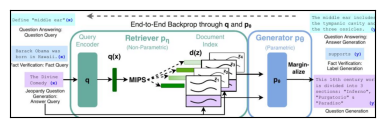

In [ ]:
# 쿼리 입력
nodes = retriever_engine.text_retrieve('Please tell me about Query Encoder') 

image_paths=[] # 이미지 경로 저장
for node in nodes:
    print(node)
    if 'is_image_caption' in node.metadata: 
        image_paths.append(node.metadata['image_path'])
plot_images(image_paths=image_paths) # 이미지 plot

### 6. 쿼리 엔진 검색 시스템 구현
이미지 캡셔닝을 통해 모든 imageDocument -> Document로 변경한 경우 RAG 시스템을 구성시 OpenAIMultiModal 클래스를 사용하지 않고 
기존 일반 텍스트 처리 모델 OpenAI 를 사용해도 무관합니다. Document 객체에서 이미지에 대한 metadata 를 추가했기 때문입니다.
단, 이미지를 입력하는 멀티 모달 RAG를 같이 구현하는 경우에는 OpenAIMultiModal을 사용해야 합니다.

In [7]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", 
                                 max_new_tokens=2000,)

query_engine = index.as_query_engine(
    llm=openai_mm_llm,
    similarity_top_k = 2,
    # image_similarity_top_k = 0
)

In [9]:
from llama_index.core import PromptTemplate
# 프롬프트 템플릿 정의
template = (
    "제공 된 정보를 참고하여 한국어로 답변을 해주세요.\n"
    "{query_str}\n"
)
prompt_template = PromptTemplate(template)

In [10]:
query_str = "Please tell me about Query Encoder"
final_prompt = prompt_template.format(query_str=query_str)
response = query_engine.query(final_prompt)

# prompt와 response 출력
print("Prompt : ", query_str)
print(f'Response :\n{response}')


Prompt :  Please tell me about Query Encoder
Response :
질문 인코더(Question Encoder)는 입력된 질문을 인코딩하는 역할을 합니다. 예를 들어, "Barack Obama was born in Hawaii."와 같은 사실 검증 질문이나 "The Divine Comedy"와 같은 퀴즈 질문을 q(x)로 인코딩합니다. 이 인코딩된 질문은 이후 관련 문서를 검색하는 데 사용됩니다. 질문 인코더는 질의응답 시스템에서 중요한 첫 번째 단계로, 입력 질문을 처리하여 시스템이 이해할 수 있는 형태로 변환합니다.


[NodeWithScore(node=TextNode(id_='c2343359-32ce-4902-b3c5-056e78dfef93', embedding=None, metadata={'source': '', 'image_id': '1515c0fa-3dd2-4dc5-913a-abb8dc5f5d08', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b0521fd8-6b37-4c88-8b9b-daa4ab444278', node_type='4', metadata={'source': '', 'image_id': '1515c0fa-3dd2-4dc5-913a-abb8dc5f5d08', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg'}, hash='b602054fd8396651f079d805f7ef448fc814e81113d92dd67e0ec881b53ce673')}, metadata_template='{key}: {value}', metadata_separator='\n', text='이 이미지는 자연어 처리(NLP) 모델의 작동 과정을 설명하는 다이어그램입니다. 이미지의 주요 구성 요소는 다음과 같습니다:\n\n1. **Question Encoder**: 입력 질문이 주어지면, 이를 q(x)로

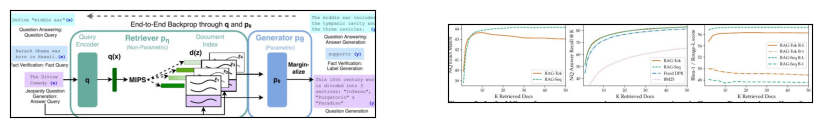

In [ ]:
image_paths=[]
for k, node_list in response.metadata.items():
    for node_with_score in node_list:
        if 'is_image_caption' in node_with_score.metadata:
            image_paths.append(node_with_score.metadata['image_path'])
plot_images(image_paths)